# **PCA Compression**

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [4]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

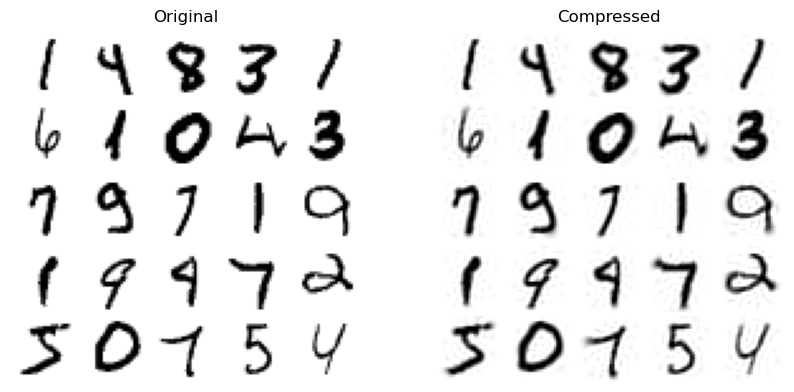

In [5]:
import matplotlib.pyplot as plt

# Plot original and compressed images
plt.figure(figsize=(10, 5))
for idx, X in enumerate((X_train[::2100], X_reduced[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            if idx == 0:  # Original images
                image = X[row * 5 + col].reshape(28, 28)
            else:  # Compressed images
                image = pca.inverse_transform(X[row * 5 + col]).reshape(28, 28)
            plt.imshow(image, cmap="binary", vmin=0, vmax=255, extent=(col, col + 1, row, row + 1))
    plt.axis([0, 5, 0, 5])
    plt.axis("off")
plt.show()

# **Incremental PCA + memory-map**

In [6]:
from sklearn.decomposition import IncrementalPCA
import numpy as np

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [7]:
filename = "mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  
X_mmap.flush()

In [8]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

In [9]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [10]:
%time rnd_clf.fit(X_train, y_train)

CPU times: user 41.3 s, sys: 422 ms, total: 41.7 s
Wall time: 42.2 s


RandomForestClassifier(random_state=42)

In [11]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [12]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [13]:
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 2min, sys: 213 ms, total: 2min
Wall time: 2min 1s


RandomForestClassifier(random_state=42)

In [14]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

**PCA + LLE**

In [15]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import make_pipeline

In [17]:
X_sample, y_sample = X_train[:5000], y_train[:5000]

In [18]:
pca_lle = make_pipeline(PCA(n_components=0.95),
                        LocallyLinearEmbedding(n_components=2, random_state=42))

%time X_pca_lle_reduced = pca_lle.fit_transform(X_sample)

CPU times: user 20.9 s, sys: 2.9 s, total: 23.8 s
Wall time: 4.56 s


t-SNE

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
%time X_reduced = tsne.fit_transform(X_sample)

CPU times: user 2min 39s, sys: 10.4 s, total: 2min 50s
Wall time: 24.3 s


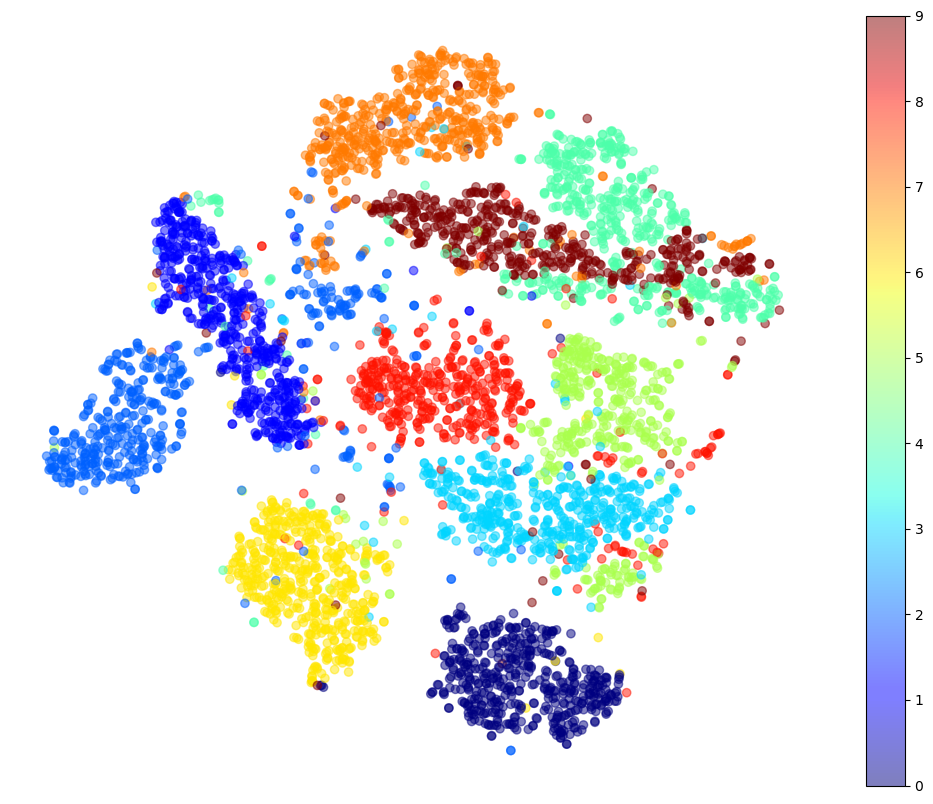

In [20]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()